In [2]:
# Install necessary libraries
!pip install --quiet pandas matplotlib

In [3]:
# Imports
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import Tuple, List, Dict

plt.rcParams['figure.figsize'] = (9,5)

In [4]:
# GridWorld Environment
class GridWorld:
    def __init__(self,
                 width:int=6,
                 height:int=6,
                 start:Tuple[int,int]=(0,0),
                 goal:Tuple[int,int]=(5,5),
                 obstacles:List[Tuple[int,int]]=None,
                 default_reward:float=-0.04,
                 goal_reward:float=1.0):
        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.obstacles = set(obstacles) if obstacles else set()
        self.default_reward = default_reward
        self.goal_reward = goal_reward
        # Actions: Up, Right, Down, Left (dx, dy)
        self.actions = [(0,-1),(1,0),(0,1),(-1,0)]
        self.action_names = ['U','R','D','L']
        self.reset()

    def in_bounds(self, s:Tuple[int,int]) -> bool:
        x,y = s
        return 0 <= x < self.width and 0 <= y < self.height

    def is_terminal(self, s:Tuple[int,int]) -> bool:
        return s == self.goal

    def step(self, action:int):
        """Take action index (0..3). Returns (next_state, reward, done)."""
        if self.is_terminal(self.state):
            return self.state, 0.0, True
        dx,dy = self.actions[action]
        nx = self.state[0] + dx
        ny = self.state[1] + dy
        ns = (nx, ny)
        # bump into wall or obstacle -> stay
        if (not self.in_bounds(ns)) or (ns in self.obstacles):
            ns = self.state
        self.state = ns
        if self.is_terminal(ns):
            return ns, self.goal_reward, True
        else:
            return ns, self.default_reward, False

    def reset(self):
        self.state = self.start
        return self.state

    def states(self):
        S = []
        for y in range(self.height):
            for x in range(self.width):
                s = (x,y)
                if s not in self.obstacles:
                    S.append(s)
        return S

    def render_policy(self, policy:Dict[Tuple[int,int],int]):
        """Print human-friendly grid policy (S start, G goal, X obstacle)."""
        grid = [[' ' for _ in range(self.width)] for __ in range(self.height)]
        for y in range(self.height):
            for x in range(self.width):
                s = (x,y)
                if s in self.obstacles:
                    grid[y][x] = 'X'
                elif s == self.goal:
                    grid[y][x] = 'G'
                elif s == self.start:
                    grid[y][x] = 'S'
                elif s in policy:
                    grid[y][x] = self.action_names[policy[s]]
                else:
                    grid[y][x] = '.'
        # Print rows top-to-bottom (y=0 is top)
        for row in grid:
            print(' '.join(row))

In [5]:
# Policy Iteration (classic)
def policy_evaluation(env:GridWorld, policy:Dict, gamma:float=0.99, theta:float=1e-6):
    V = {s:0.0 for s in env.states()}
    while True:
        delta = 0.0
        for s in env.states():
            if env.is_terminal(s):
                continue
            a = policy[s]
            # Temporarily set env.state to s to use env.step logic
            saved = env.state
            env.state = s
            ns, r, done = env.step(a)
            env.state = saved
            v = r + gamma * (0.0 if done else V[ns])
            delta = max(delta, abs(V[s] - v))
            V[s] = v
        if delta < theta:
            break
    return V

def policy_iteration(env:GridWorld, gamma:float=0.99, max_iters:int=1000):
    # Initialize random policy for non-terminal states
    policy = {}
    for s in env.states():
        if env.is_terminal(s):
            continue
        policy[s] = random.randrange(len(env.actions))
    for it in range(max_iters):
        V = policy_evaluation(env, policy, gamma=gamma)
        policy_stable = True
        for s in env.states():
            if env.is_terminal(s):
                continue
            old_a = policy[s]
            best_a = old_a
            best_val = -1e9
            for a in range(len(env.actions)):
                saved = env.state
                env.state = s
                ns, r, done = env.step(a)
                env.state = saved
                val = r + gamma * (0.0 if done else V[ns])
                if val > best_val:
                    best_val = val
                    best_a = a
            policy[s] = best_a
            if best_a != old_a:
                policy_stable = False
        if policy_stable:
            break
    return policy, V

In [6]:
# Q-Learning (tabular)
def q_learning(env:GridWorld,
               episodes:int=8000,
               alpha:float=0.6,
               gamma:float=0.99,
               epsilon:float=0.3,
               epsilon_decay:float=0.9996,
               max_steps:int=200,
               seed:int=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    episode_rewards = []
    success = 0
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        for step in range(max_steps):
            # epsilon-greedy
            if np.random.rand() < epsilon:
                a = np.random.randint(len(env.actions))
            else:
                a = int(np.argmax(Q[s]))
            ns, r, done = env.step(a)
            total_r += r
            # Q update
            Q[s][a] += alpha * (r + gamma * (0.0 if done else np.max(Q[ns])) - Q[s][a])
            s = ns
            if done:
                if env.is_terminal(s):
                    success += 1
                break
        episode_rewards.append(total_r)
        epsilon *= epsilon_decay
    # derive greedy policy and state-value approx from Q
    policy = {}
    V = {}
    for s in env.states():
        if env.is_terminal(s):
            continue
        greedy_a = int(np.argmax(Q[s]))
        policy[s] = greedy_a
        V[s] = np.max(Q[s])
    return Q, policy, V, episode_rewards, success

In [7]:
# Utility: moving average
def moving_average(x, w):
    if len(x) < w:
        return np.array(x)
    return np.convolve(x, np.ones(w), 'valid')/w

In [8]:
# Utility: pretty arrow policy plot
def policy_grid_to_text(env:GridWorld, policy:Dict):
    try:
        grid = [[' ' for _ in range(env.width)] for __ in range(env.height)]
        for y in range(env.height):
            for x in range(env.width):
                s = (x,y)
                if s in env.obstacles:
                    grid[y][x] = 'X'
                elif s == env.goal:
                    grid[y][x] = 'G'
                elif s == env.start:
                    grid[y][x] = 'S'
                elif s in policy:
                    grid[y][x] = env.action_names[policy[s]]
                else:
                    grid[y][x] = '.'
        return grid
    except Exception as e:
        return None

In [9]:
# Config / Environment choice
# If you want a different layout, change GRID_CHOICE or set GRID_CHOICE=4 and provide custom obstacles.
GRID_CHOICE = 3  # 1=4x4, 2=5x5 walls, 3=6x6 maze (default), 4=custom

if GRID_CHOICE == 1:
    W,H = 4,4
    start=(0,0); goal=(3,3)
    obstacles = []
elif GRID_CHOICE == 2:
    W,H = 5,5
    start=(0,0); goal=(4,4)
    obstacles = [(1,1),(2,2),(3,1)]
elif GRID_CHOICE == 3:
    W,H = 6,6
    start=(0,0); goal=(5,5)
    obstacles = [(1,1),(2,1),(3,1),(3,2),(3,3),(1,4)]
else:
    # custom: edit below
    W,H = 6,6
    start=(0,0); goal=(5,5)
    obstacles = [(1,1),(2,1),(3,1),(3,2),(3,3),(1,4)]

env = GridWorld(width=W, height=H, start=start, goal=goal, obstacles=obstacles, default_reward=-0.04)

In [10]:
# Run Policy Iteration
pi_policy, pi_V = policy_iteration(env, gamma=0.99)
print("Policy Iteration policy (text):")
env.render_policy(pi_policy)
print()

# Run Q-Learning
Q, q_policy, q_V, rewards, successes = q_learning(env,
                                                  episodes=8000,
                                                  alpha=0.6,
                                                  gamma=0.99,
                                                  epsilon=0.3,
                                                  epsilon_decay=0.9996,
                                                  max_steps=200,
                                                  seed=42)
print("Q-learning learned policy (text):")
env.render_policy(q_policy)
print(f"\nQ-learning successes (episodes reaching goal during training): {successes} / {len(rewards)}")
print()

Policy Iteration policy (text):
S R R R R D
D X X X R D
R R D X R D
R R D X R D
D X R R R D
R R R R R G

Q-learning learned policy (text):
S R R R R D
D X X X R D
R D D X R D
R R D X R D
U X R R R D
R R U R R G

Q-learning successes (episodes reaching goal during training): 8000 / 8000



In [11]:
# Comparison Summary
summary = {
    'Method': ['Policy Iteration', 'Q-Learning'],
    'Successes_for_QLearning': [None, successes],
    'Avg_value_nonterminal': [np.mean(list(pi_V.values())), np.mean(list(q_V.values()))],
    'Num_states': [len(env.states()), len(env.states())]
}
df_summary = pd.DataFrame(summary)
print("Summary:")
print(df_summary)
print()

Summary:
             Method  Successes_for_QLearning  Avg_value_nonterminal  \
0  Policy Iteration                      NaN               0.777586   
1        Q-Learning                   8000.0               0.767385   

   Num_states  
0          30  
1          30  



In [12]:
# Save outputs to /content
outdir = "/content/qlearning_policy_iteration_outputs"
os.makedirs(outdir, exist_ok=True)

In [13]:
# Save policy CSV
policy_rows = []
for y in range(H):
    for x in range(W):
        s = (x,y)
        policy_rows.append({
            'x': x,
            'y': y,
            'pi_action': pi_policy.get(s, None),
            'q_action': q_policy.get(s, None),
            'is_obstacle': s in env.obstacles,
            'is_goal': s==env.goal,
            'is_start': s==env.start
        })
pd.DataFrame(policy_rows).to_csv(os.path.join(outdir, "policies_comparison.csv"), index=False)

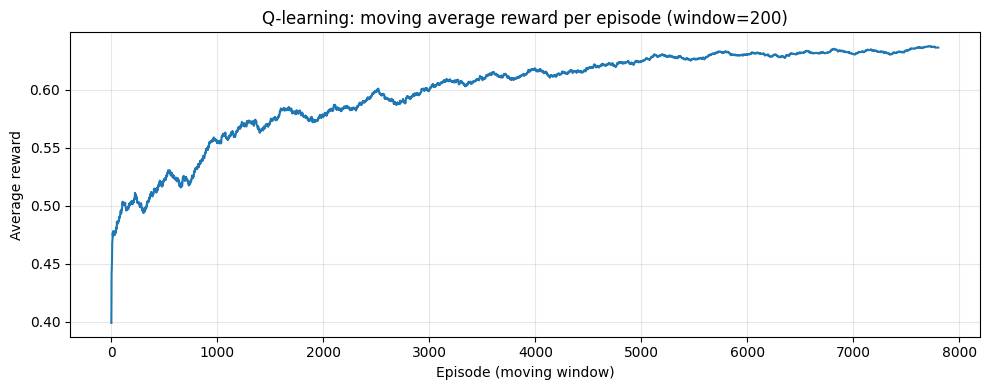

In [14]:
# Plots: Q-learning learning curve (moving average)
ma = moving_average(rewards, 200)
plt.figure(figsize=(10,4))
plt.plot(ma)
plt.title('Q-learning: moving average reward per episode (window=200)')
plt.xlabel('Episode (moving window)')
plt.ylabel('Average reward')
plt.grid(alpha=0.3)
plt.tight_layout()
lc_path = os.path.join(outdir, "q_learning_learning_curve.png")
plt.savefig(lc_path)
plt.show()

In [15]:
# Visual policy grids (text)
print("Policy Iteration policy grid (S=Start, G=Goal, X=Obstacle):")
env.render_policy(pi_policy)
print("\nQ-learning policy grid:")
env.render_policy(q_policy)
print()

Policy Iteration policy grid (S=Start, G=Goal, X=Obstacle):
S R R R R D
D X X X R D
R R D X R D
R R D X R D
D X R R R D
R R R R R G

Q-learning policy grid:
S R R R R D
D X X X R D
R D D X R D
R R D X R D
U X R R R D
R R U R R G



In [16]:
# Visual policy arrow images (simple)
# Map actions to arrows for plotting
arrow_map = {'U':'↑','R':'→','D':'↓','L':'←','G':'G','S':'S','X':'X','.':'.'}
def grid_with_arrows(env, policy):
    rows = []
    for y in range(env.height):
        row = []
        for x in range(env.width):
            s = (x,y)
            if s in env.obstacles:
                row.append('X')
            elif s == env.goal:
                row.append('G')
            elif s == env.start:
                row.append('S')
            elif s in policy:
                row.append(env.action_names[policy[s]])
            else:
                row.append('.')
        rows.append(row)
    return rows

pi_grid = grid_with_arrows(env, pi_policy)
q_grid = grid_with_arrows(env, q_policy)

In [17]:
# create a DataFrame for nicer display in notebook
pi_df = pd.DataFrame([[arrow_map[c] for c in row] for row in pi_grid])
q_df = pd.DataFrame([[arrow_map[c] for c in row] for row in q_grid])

print("Policy Iteration (arrows):")
display(pi_df)
print("Q-Learning (arrows):")
display(q_df)

Policy Iteration (arrows):


,0,1,2,3,4,5
0,S,→,→,→,→,↓
1,↓,X,X,X,→,↓
2,→,→,↓,X,→,↓
3,→,→,↓,X,→,↓
4,↓,X,→,→,→,↓
5,→,→,→,→,→,G


Q-Learning (arrows):


,0,1,2,3,4,5
0,S,→,→,→,→,↓
1,↓,X,X,X,→,↓
2,→,↓,↓,X,→,↓
3,→,→,↓,X,→,↓
4,↑,X,→,→,→,↓
5,→,→,↑,→,→,G


In [18]:
# Save summary CSV
df_summary.to_csv(os.path.join(outdir, "summary_comparison.csv"), index=False)

print(f"All outputs saved to: {outdir}")
print("Files saved: q_learning_learning_curve.png, policies_comparison.csv, summary_comparison.csv")

All outputs saved to: /content/qlearning_policy_iteration_outputs
Files saved: q_learning_learning_curve.png, policies_comparison.csv, summary_comparison.csv


## Future Enhancements:

#### Add stochastic transitions (slip probability), multiple seeds and averaged curves, or animated agent trajectories.